In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle as cp

from PIL import ImageFont, ImageDraw, Image
import glob
import os
from tqdm import tqdm
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

1.7.1 True


ModuleNotFoundError: No module named 'detectron2'

In [2]:
images = glob.glob("./imagefolder/genimages2/*.jpg")
all_masknames = glob.glob("./imagefolder/genmasks2/*.jpg")
ar_masknames = [os.path.basename(fname) for fname in all_masknames if "ar_" in fname]
eng_masknames = [os.path.basename(fname) for fname in all_masknames if "eng_" in fname]

# def get_mask_fname(fname):
#     return os.path.join("./imagefolder/masks/",os.path.basename(fname))
# get_mask_fname(images[1000]) 
len(ar_masknames),len(eng_masknames),eng_masknames[:3]   ,len(images)

(5662, 5646, ['eng_0.jpg', 'eng_1.jpg', 'eng_10000.jpg'], 8613)

In [3]:
def get_mask(fname):
    # print(fname)
    mask = cv2.imread(fname)
    im_bw = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    ret,thresh = cv2.threshold(im_bw,127,255,0)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)[-2:]
    x,y,w,h = cv2.boundingRect(contours[0])
    return [x,y,x+w,y+h]

def get_annotation_dict_from_mask(ims):

    dataset = []
    for idx,filename in enumerate(ims):
        record = {}
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        objs = []
        masks = {}
        if "ar_"+os.path.basename(filename) in ar_masknames:
            masks[0] = os.path.join("./imagefolder/genmasks2","ar_"+os.path.basename(filename))
        if "eng_"+os.path.basename(filename) in eng_masknames:
            masks[1] = os.path.join("./imagefolder/genmasks2","eng_"+os.path.basename(filename))
        for key,mask_filename in masks.items():
            obj = {
                    "bbox": get_mask(mask_filename),
                    "bbox_mode": BoxMode.XYXY_ABS,
                    # "segmentation": [poly],
                    "category_id": key,
                }
            objs.append(obj)

        record["annotations"] = objs
        dataset.append(record)
    return dataset


In [4]:
train_images = np.random.choice(images,2000,replace=False)
val_images = [im for im in images if im not in train_images]
len(val_images),len(train_images)

(6613, 2000)

In [5]:
d="train"
DatasetCatalog.register("roadsignsv1_" + d, lambda d=d: get_annotation_dict_from_mask(train_images))
MetadataCatalog.get("roadsignsv1_" + d).set(thing_classes=["ARABIC","ENGLISH"])
d="val"
DatasetCatalog.register("roadsignsv1_" + d, lambda d=d: get_annotation_dict_from_mask(val_images))
MetadataCatalog.get("roadsignsv1_" + d).set(thing_classes=["ARABIC","ENGLISH"])

roadsign_metadata = MetadataCatalog.get("roadsignsv1_train")

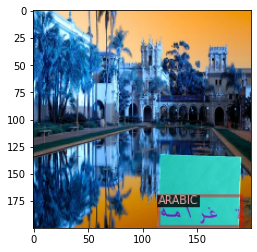

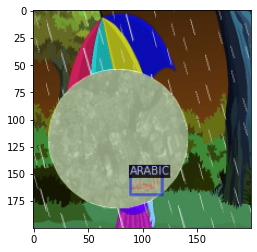

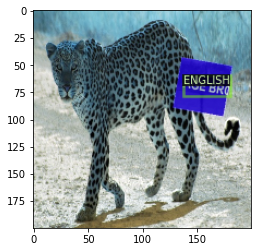

In [64]:
import random
import matplotlib.pyplot as plt
%matplotlib inline
dataset_dicts = get_annotation_dict_from_mask(train_images)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=roadsign_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

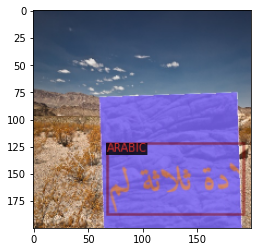

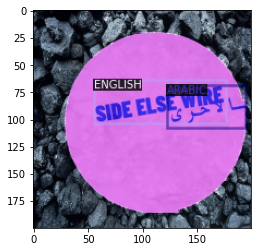

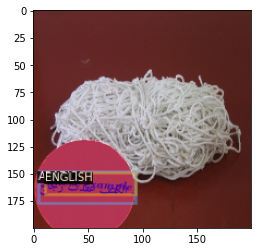

In [82]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=roadsign_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image())
    plt.show()

In [7]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("roadsignsv1_train",)
cfg.DATASETS.TEST = ("roadsignsv1_val",)
cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.WEIGHTS = "model_final_280758.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 15000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.TEST.EVAL_PERIOD = 100
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

m eta: 0:04:40  iter: 13859  total_loss: 0.110  loss_cls: 0.030  loss_box_reg: 0.073  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  time: 0.2502  data_time: 0.0010  lr: 0.000250  max_mem: 1824M
[01/04 23:09:05 d2.utils.events]:  eta: 0:04:35  iter: 13879  total_loss: 0.105  loss_cls: 0.033  loss_box_reg: 0.063  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  time: 0.2502  data_time: 0.0010  lr: 0.000250  max_mem: 1824M
[01/04 23:09:36 d2.data.common]: Serializing 6613 elements to byte tensors and concatenating them all ...
[01/04 23:09:36 d2.data.common]: Serialized dataset takes 1.44 MiB
[01/04 23:09:36 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
WARNING [01/04 23:09:36 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[01/04 23:09:36 d2.utils.events]:  eta: 0:04:30  iter: 13899  total_loss: 0.092  loss_cls: 0.029  loss_b

In [8]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("roadsignsv1_train",)
cfg.DATASETS.TEST = ("roadsignsv1_val",)
cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.WEIGHTS = "model_final_280758.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1500    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.TEST.EVAL_PERIOD = 100
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set the testing threshold for this model
# cfg.DATASETS.TEST = ("boardetect_val", )
predictor = DefaultPredictor(cfg)

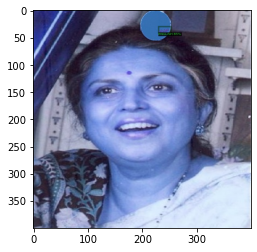

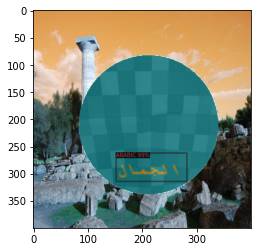

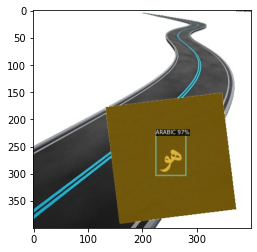

In [9]:
# dataset_dicts = get_annotation_dict_from_mask(train_images)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=roadsign_metadata, scale=1)
    # out = visualizer.draw_dataset_dict(d)
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

../input/eval_oics\1.jpg


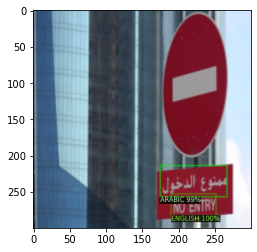

../input/eval_oics\3972-17fm507.jpg


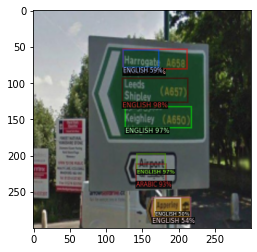

../input/eval_oics\5cec327a8c0c03a2b03f3545a9f0a9f6--arabic-lessons-street-signs.jpg


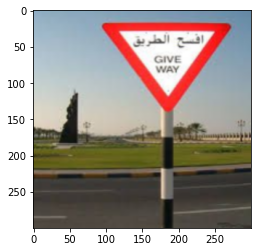

../input/eval_oics\cc6ce9d7086cc8e9f106639fce00dc80--arabic-alphabet-muslim.jpg


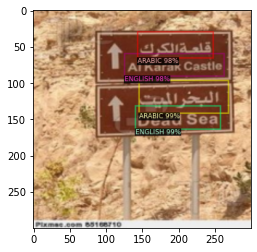

../input/eval_oics\download (2).jpg


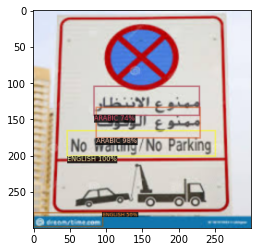

../input/eval_oics\download.jpg


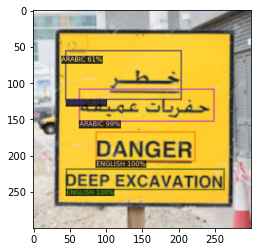

../input/eval_oics\images (1).jpg


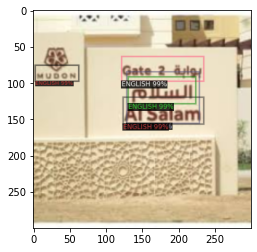

../input/eval_oics\images (2).jpg


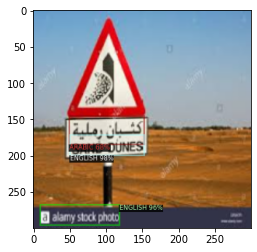

../input/eval_oics\images.jpg


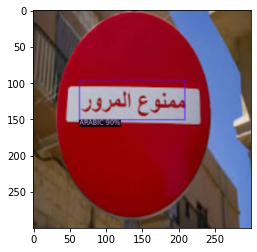

../input/eval_oics\pushtocross.jpg


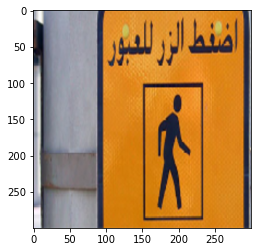

In [57]:
eval_images = glob.glob("../input/eval_oics/*.jpg")
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set the testing threshold for this model
# cfg.DATASETS.TEST = ("boardetect_val", )
predictor = DefaultPredictor(cfg)
for d in eval_images:
    print(d)
    img = cv2.imread(d)
    img = cv2.resize(img,(200,200),interpolation = cv2.INTER_AREA)
    outputs = predictor(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=roadsign_metadata, scale=1.5)
    # out = visualizer.draw_dataset_dict(d)
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image())
    plt.show()

In [23]:
outputs

{'instances': Instances(num_instances=1, image_height=183, image_width=275, fields=[pred_boxes: Boxes(tensor([[ 53.5837,  58.7136, 194.5611,  95.7634]], device='cuda:0')), scores: tensor([0.8816], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}

../input/eval_oics\1.jpg


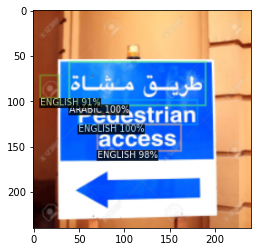

In [63]:
eval_images = glob.glob("../input/eval_oics/*.jpg")
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set the testing threshold for this model
# cfg.DATASETS.TEST = ("boardetect_val", )
predictor = DefaultPredictor(cfg)
for d in eval_images:
    print(d)
    d= "../input/eval_oics/39435845-street-sign-with-arrow-pedestrian-access-written-in-arabic-and-english-.jpg"
    img = cv2.imread(d)
    img = cv2.resize(img,(200,200),interpolation = cv2.INTER_AREA)
    outputs = predictor(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=roadsign_metadata, scale=1.2)
    # out = visualizer.draw_dataset_dict(d)
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image())
    plt.show()
    break